# Benchmarking Matrix Multiplication

One of the most basic building blocks of numerical linear algebra is the computation of matrix multiplication: given an $m \times n$ matrix $A$ and an $n \times p$ matrix $B$, compute the $m \times p$ matrix $C = AB$.   The entries of $C$ are given by the exact formula:
$$
C_{ik} = \sum_{j=1}^n A_{ij} B_{jk}
$$
but there are many ways to implement this computation.   $\approx 2mnp$ flops (floating-point additions and multiplications) are required, but they can re-ordered arbitrarily, leading to $\sim (mnp)!$ possible orderings.

It turns out that the ordering of the operations in the matrix multiplication has a *huge* impact on performance, along with low-level details of the inner loops.  Basically, three factors make the implementation of efficient matrix multiplication highly nontrivial:

* [Caches](https://en.wikipedia.org/wiki/CPU_cache): the matrix accesses must be reordered to obtain [temporal locality](https://en.wikipedia.org/wiki/Locality_of_reference) and hence efficient memory (cache) usage.
* [Registers](https://en.wikipedia.org/wiki/Processor_register): at the lowest level, the CPU registers form a kind of ideal cache.  The innermost loops of the matrix multiplication need to be unrolled in order to load many values into registers and perform as much work with them as possible (essentially a small submatrix multiplication).  It turns out that a [lot of tricks](http://cscads.rice.edu/workshops/july2007/autotune-slides-07/Frigo.pdf) are required to do this well.
* [SIMD instructions](https://en.wikipedia.org/wiki/SIMD): modern CPUs include special instructions that can perform several arithmetic operations at once (e.g. 2, 4, or even 8 `Float64` operations), and to get the full benefit of these operations typically requires hand coding. 

As a consequence, there is a huge performance gap between the most obvious three-loop matrix-multiplication code and highly optimized code.  This gap has become the central factor in the design of dense linear-algebra libraries for several decades, especially the industry-standard free/open-source the [LAPACK](https://en.wikipedia.org/wiki/LAPACK) library: nearly all dense linear algebra is now organized around highly optimized [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) libraries.

Because Julia benefits from fast compilers, we can illustrate this performance gap fairly with simple Julia code.  (In contrast, similar implementation in Matlab or Python would be orders of magnitude slower, and would demonstrate mostly language rather than the algorithmic effects.)

## Naive algorithm

The following is the simplest, most obvious, matrix-multiplication algorithm: just three nested loops, implementing a dot product for each output $C_{ik}$.

The only concessions we have made to performance concerns here are (1) we implement an in-place `matmul!` variant that operates on a pre-existing `C` array, to avoid benchmarking the memory allocation/deallocation and (2) we use the `@inbounds` macro to turn off array bounds-checking in Julia for the inner loop.   Together, these make less than a factor of two difference in speed.

In [1]:
# compute C = A * B, using naive matrix-multiplication algorithm,
# with a pre-allocated output array C.  ("!" is a Julia convention
# for functions that modify their arguments.)
function matmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    for i = 1:m
        for k = 1:p
            c = zero(eltype(C))
            for j = 1:n
                @inbounds c += A[i,j] * B[j,k]
            end
            @inbounds C[i,k] = c
        end
    end
    return C
end

# a wrapper that allocates C of an appropriate type
matmul(A, B) = matmul!(Array{promote_type(eltype(A), eltype(B))}(undef,
                             size(A,1), size(B,2)),
                       A, B)

matmul (generic function with 1 method)

In [3]:
using LinearAlgebra

In [4]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
norm(matmul(A,B) - A * B)

1.0114613123884174e-15

### Benchmarking naive `matmul`

Here, we will benchmark our naive `matmul` implementation against the highly optimized [OpenBLAS library](http://www.openblas.net/) that Julia uses for its built-in matrix multiplication.   Like `matmul!`, we will call OpenBLAS with pre-allocated output via `mul!(C, A, B)` instead of the simpler `A * B`.  By default, OpenBLAS uses multiple CPU cores, which gives it an "unfair" parallel speedup, but we can disable this for benchmarking purposes:

In [5]:
# for benchmarking, use only single-threaded BLAS:
BLAS.set_num_threads(1)

We will benchmark $n \times n$ matrix multiplications for various $n$ from 10 to 1000.  Julia's `@elapsed ...code...` macro is useful for benchmarking: it times the code and returns the time in seconds.   As we go, we will print the ratio of the naive time to the optimized time, to see the slowdown of our naive code.

In [7]:
N = round.(Int, 10 .^ range(1, 3, length=50))  # 50 sizes from 10 to 1000
# alternatively, use N = 10:1000 to see some interesting patterns due to cache associativity etc.
t = Float64[]
t0 = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(t, @elapsed matmul!(C,A,B))
    push!(t0, @elapsed mul!(C,A,B))
    println("finished n = $n: slowdown of ", t[end]/t0[end])
end

finished n = 10: slowdown of 0.007929565953053528
finished n = 11: slowdown of 0.4861348853132489
finished n = 12: slowdown of 0.7726173197871311
finished n = 13: slowdown of 0.9752704791344666
finished n = 15: slowdown of 1.223292469352014
finished n = 16: slowdown of 1.806520577231427
finished n = 18: slowdown of 1.9276422764227639
finished n = 19: slowdown of 1.9614170466502983
finished n = 21: slowdown of 3.1380701210052746
finished n = 23: slowdown of 0.9495838978130444
finished n = 26: slowdown of 0.03978348477924113
finished n = 28: slowdown of 3.9863760217983653
finished n = 31: slowdown of 3.7339220014716705
finished n = 34: slowdown of 3.1405019234291998
finished n = 37: slowdown of 5.269446098868373
finished n = 41: slowdown of 4.417910447761194
finished n = 45: slowdown of 5.156327701625758
finished n = 49: slowdown of 5.9289592760181
finished n = 54: slowdown of 6.939094730667709
finished n = 60: slowdown of 8.008778287831198
finished n = 66: slowdown of 8.110087573103845


In [9]:
using PyPlot
PyPlot.svg(true) # SVG output for nicer plots

true

Now, we will plot the results.  Since the number of flops is $2n^3$, we will plot $2n^3 / t$ for time $t$ in microseconds in order to plot the **gigaflops rate** (billions of flops per second).  If you naively think of a CPU as a box that performs floating-point instructions at a fixed rate, with all other instructions being negligible (a picture that *may* have been true circa 1985), this would be a flat horizontal line independent of $n$, but we will see that reality is quite different.

The OpenBLAS library gets an "unfair" factor of 4 speedup on typical modern Intel processors thanks to hand-coded support for [AVX](https://en.wikipedia.org/wiki/Advanced_Vector_Extensions) SIMD instructions, which perform 4 double-precision floating-point operations simultaneously, so we will divide the BLAS performance by 4 for comparison purposes.

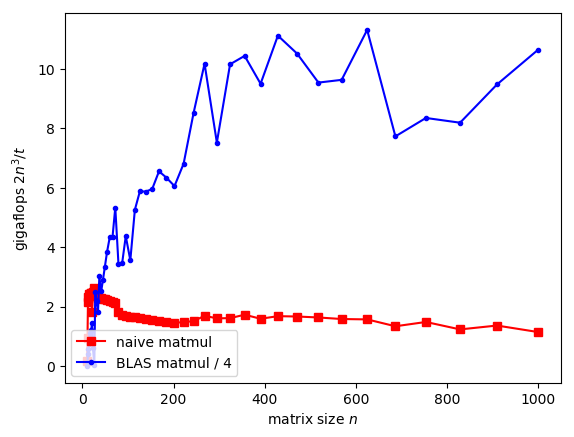

PyObject <matplotlib.legend.Legend object at 0x142f66208>

In [10]:
plot(N, 2N.^3 ./ t * 1e-9, "rs-")
plot(N, 2N.^3 ./ t0 * 1e-9 / 4, "b.-")
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive matmul", "BLAS matmul / 4"], loc="lower left")

### Naive matmul in C

You may be suspicious that the problem is simply that Julia is slow.   We can check this hypothesis by implementing the same algorithm in C, compiling it, and then calling it by Julia's built-in `ccall` instruction that makes it [easy to call C from Julia](http://docs.julialang.org/en/latest/manual/calling-c-and-fortran-code/).

In [15]:
# C implementation:
Cmatmul = """
void Cmatmul(int m, int n, int p, double *C, double *A, double *B)
{
    int i, j, k;
    for (i = 0; i < m; ++i)
        for (j = 0; j < p; ++j) {
            double c = 0.0;
            for (k = 0; k < n; ++k)
                c += A[i + m*k] * B[k + n*j];
            C[i + m*j] = c;
    }
}
"""
# compile to a shared library by piping Cmatmul to gcc:
# (only works if you have gcc installed)
const Clib = tempname()
using Libdl
open(`gcc -fPIC -O3 -xc -shared -o $(Clib * "." * dlext) -`, "w") do f
    print(f, Cmatmul)
end

# define a Julia cmatmul! function that simply calls the C code in the shared library we compiled
function cmatmul!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    ccall(("Cmatmul", Clib), Cvoid, (Cint, Cint, Cint, Ptr{Float64}, Ptr{Float64}, Ptr{Float64}),
          m, n, p, C, A, B)
    return C
end
cmatmul(A, B) = cmatmul!(Array{promote_type(eltype(A), eltype(B))}(undef,
                               size(A,1), size(B,2)),
                         A, B)

cmatmul (generic function with 1 method)

In [16]:
# correctness check:
A = rand(5,6)
B = rand(6,7)
norm(cmatmul(A,B) - A * B)

6.843874359417885e-16

Now, let's benchmark it and print out the "speedup" compared to pure Julia.  We see that it is **not actually much faster** (and in fact is occasionally slower).  Julia's main claim to fame is that it is a dynamic language (like Python or Matlab) that stays within a factor of 2 (usually better) of C.

In [17]:
tc = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tc, @elapsed cmatmul!(C,A,B))
    println("finished n = $n: speedup of ", tc[end]/t[length(tc)])
end

finished n = 10: speedup of 1.3802634978041848
finished n = 11: speedup of 0.9816901408450703
finished n = 12: speedup of 1.02128991859737
finished n = 13: speedup of 1.1547807712625462
finished n = 15: speedup of 1.6939871152469579
finished n = 16: speedup of 1.0686390532544379
finished n = 18: speedup of 0.9713201180936314
finished n = 19: speedup of 1.0371959942775395
finished n = 21: speedup of 0.7576626458374529
finished n = 23: speedup of 1.0283297666360949
finished n = 26: speedup of 1.020065642249739
finished n = 28: speedup of 1.0219298245614035
finished n = 31: speedup of 1.9062352199274792
finished n = 34: speedup of 2.2322095193653757
finished n = 37: speedup of 1.0817641340958926
finished n = 41: speedup of 1.2387442320369149
finished n = 45: speedup of 1.0731852071664378
finished n = 49: speedup of 1.2616099366557276
finished n = 54: speedup of 1.141342631727247
finished n = 60: speedup of 1.0122027251244408
finished n = 66: speedup of 1.1371501376844355
finished n = 72: 

## Cache-oblivious matrix-multiplication

As a first step in the right direction, we'll implement a [cache-oblivious algorithm](https://en.wikipedia.org/wiki/Cache-oblivious_algorithm) for matrix multiplication: divide the matrices into four submatrices which are multiplied *recursively* until a sufficiently large base case is reached (large enough to amortize the recursion overhead).   This strategy erases the steep performance drop-off that occurs for large $n$ where the matrix goes out-of-cache, at the cost of ~25 lines of code rather than ~10 for the naive loops.

(It still doesn't match the OpenBLAS performance because it fails to address the other two problems: unrolling and optimizing the base cases to optimize register utilization, and coding for SIMD instructions.)

In [18]:
function add_matmul_rec!(m,n,p, i0,j0,k0, C,A,B)
    if m+n+p <= 64   # base case: naive matmult for sufficiently large matrices
        for i = 1:m
            for k = 1:p
                c = zero(eltype(C))
                for j = 1:n
                    @inbounds c += A[i0+i,j0+j] * B[j0+j,k0+k]
                end
                @inbounds C[i0+i,k0+k] += c
            end
        end
    else
        m2 = m ÷ 2; n2 = n ÷ 2; p2 = p ÷ 2
        add_matmul_rec!(m2, n2, p2, i0, j0, k0, C, A, B)
        
        add_matmul_rec!(m-m2, n2, p2, i0+m2, j0, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p2, i0, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n2, p-p2, i0, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p2, i0+m2, j0+n2, k0, C, A, B)
        add_matmul_rec!(m2, n-n2, p-p2, i0, j0+n2, k0+p2, C, A, B)
        add_matmul_rec!(m-m2, n2, p-p2, i0+m2, j0, k0+p2, C, A, B)
        
        add_matmul_rec!(m-m2, n-n2, p-p2, i0+m2, j0+n2, k0+p2, C, A, B)
    end
    return C
end

function matmul_rec!(C, A, B)
    m,n = size(A)
    n,p = size(B)
    size(C) == (m,p) || error("incorrect dimensions ", size(C), " ≠ $m × $p")
    fill!(C, 0)
    return add_matmul_rec!(m,n,p, 0,0,0, C,A,B)
end


matmul_rec(A, B) = matmul_rec!(Array{promote_type(eltype(A), eltype(B))}(undef,
                                     size(A,1), size(B,2)),
                               A, B)

matmul_rec (generic function with 1 method)

In [19]:
# correctness check:
A = rand(50,60)
B = rand(60,70)
norm(matmul_rec(A,B) - A * B)

2.0532103344521445e-13

In [20]:
tco = Float64[]
for n in N
    A = zeros(n,n)
    B = zeros(n,n)
    # preallocate output C so that allocation is not included in timing
    C = zeros(n,n)
    push!(tco, @elapsed matmul_rec!(C,A,B))
    println("finished n = $n: slowdown of ", tco[end]/t0[length(tc)])
end

finished n = 10: slowdown of 0.09981842117131802
finished n = 11: slowdown of 6.185928526610629e-5
finished n = 12: slowdown of 3.515651634228622e-5
finished n = 13: slowdown of 4.4568497095339234e-5
finished n = 15: slowdown of 6.330728230503752e-5
finished n = 16: slowdown of 7.71910186194958e-5
finished n = 18: slowdown of 0.00010759895643705166
finished n = 19: slowdown of 0.00012529433201575538
finished n = 21: slowdown of 0.0001699905935557062
finished n = 23: slowdown of 0.00022258695658747298
finished n = 26: slowdown of 0.00031542911967188725
finished n = 28: slowdown of 0.0003753080560465141
finished n = 31: slowdown of 0.0005284763310616957
finished n = 34: slowdown of 0.0006882457690484755
finished n = 37: slowdown of 0.0009032733293297634
finished n = 41: slowdown of 0.0012212577378938824
finished n = 45: slowdown of 0.001607894241362623
finished n = 49: slowdown of 0.002026940325614501
finished n = 54: slowdown of 0.002684756862771319
finished n = 60: slowdown of 0.003747

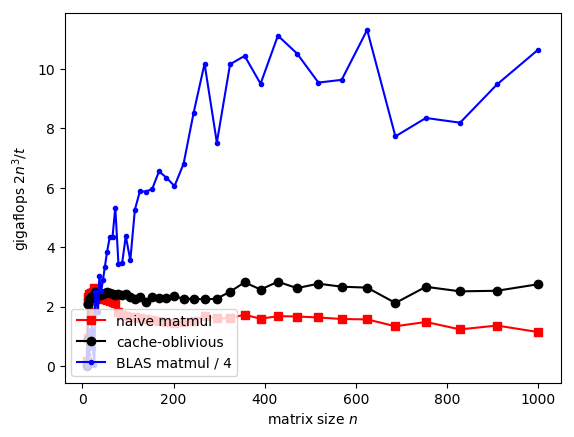

PyObject <matplotlib.legend.Legend object at 0x146cbf630>

In [21]:
plot(N, 2N.^3 ./ t * 1e-9, "rs-")
plot(N, 2N.^3 ./ tco * 1e-9, "ko-")
plot(N, 2N.^3 ./ t0 * 1e-9 / 4, "b.-")
ylabel(L"gigaflops $2n^3/t$")
xlabel(L"matrix size $n$")
legend(["naive matmul", "cache-oblivious", "BLAS matmul / 4"], loc="lower left")